# LightGBM

https://lightgbm.readthedocs.io/en/latest/Python-Intro.html

In [2]:
import lightgbm as lgb
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_predict
import numpy as np
from datetime import datetime
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt


Importing data and defining column names

In [5]:
data_path = "../../data/"
label_col = "Label"

train_data = pd.read_csv(data_path + "train.csv")
test_data = pd.read_csv(data_path + "test.csv")

drop_cols = [
    "time",
    "SNo"
]

X = train_data.drop(drop_cols + ["Label"], axis=1).copy()
y = train_data[label_col].copy()

Squaring cols + magnitude of the wind

Cross validation

In [7]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 5-folds as an example, adjust as necessary

In [8]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.fit_transform(X_valid)
X_train = pd.DataFrame(X_train, columns=X.columns)

Train lightgbm

In [16]:
# Placeholder for scores and models
scores = []
models = []  # To store trained models

# Cross-validation loop
for train_index, test_index in kf.split(X):
    X_train, X_valid = X.iloc[train_index,:], X.iloc[test_index,:]
    y_train, y_valid = y[train_index], y[test_index]
    
    # Convert data to LightGBM datasets
    train_data = lgb.Dataset(X_train, label=y_train)
    valid_data = lgb.Dataset(X_valid, label=y_valid)
    
    # Define parameters (adjust these as per your needs)
    parameters = {
        "objective": "multiclass",
        "num_class": 3,
        'eval_matric': ["accuracy"],
        'is_unbalance': 'true',
    #     'boosting': 'gbdt',
    #     "max_depth": 5,
    #     "num_leaves": 100,
    #     "num_iterations": 100,
    #     "n_jobs": 1,
    #     "lambda_l1": 0.1,  # L1 regularization term. Adjust as needed.
    #     "lambda_l2": 0.1  # L2 regularization term. Adjust as needed.
    }

    # Train model
    model_lgbm = lgb.LGBMClassifier(**parameters)
    
    model_lgbm.fit(train_data.data, y=train_data.get_label())
    
    # Append model to the models list
    models.append(model_lgbm)
    
    # Predict and score
    y_pred = model_lgbm.predict(X_valid)
    y_pred_label = np.round(y_pred)  # For classification, you might need to adjust this
    score = accuracy_score(y_valid, y_pred_label)
    scores.append(score)

print()
print(scores)
print(np.mean(scores))
print(np.std(scores))

[LightGBM] [Warning] Unknown parameter: eval_matric
[LightGBM] [Warning] Unknown parameter: eval_matric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002331 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7966
[LightGBM] [Info] Number of data points in the train set: 35808, number of used features: 33
[LightGBM] [Info] Start training from score -0.242046
[LightGBM] [Info] Start training from score -3.199050
[LightGBM] [Info] Start training from score -1.747672
[LightGBM] [Warning] Unknown parameter: eval_matric
[LightGBM] [Warning] Unknown parameter: eval_matric
[LightGBM] [Warning] Unknown parameter: eval_matric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001839 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.

In [ ]:
print(scores)
print(np.mean(scores))
print(np.std(scores))

In [38]:
model = models[2]

In [39]:
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_valid)

In [45]:
def accuracy( y_true, y_pred):
    acc = np.mean(y_true == y_pred)
    return acc

In [46]:
accuracy(y_valid_pred, valid_data.get_label())

0.915437890974084

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

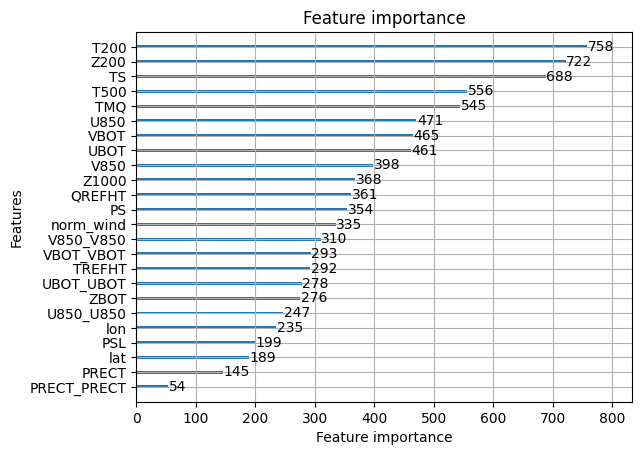

In [47]:
lgb.plot_importance(model)

---

Test data

In [48]:
test_data_sel = test_data.drop(drop_cols, axis=1)
test_data_sel = scaler.fit_transform(test_data_sel)

In [32]:
test_data['Label'] = model_lgbm.predict(test_data_sel)

In [16]:
submission = test_data[["SNo", "Label"]].copy()

In [18]:
# submition.drop("index", axis=1, inplace=True)
submission.to_csv(f"predictions_lightgbm_{datetime.now()}.csv", index=False)